In [1]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.framework import ops
ops.reset_default_graph()

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
np.random.seed(20)
sess = tf.Session()

In [3]:
mnist = input_data.read_data_sets('temp', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting temp\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting temp\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting temp\t10k-images-idx3-ubyte.gz
Extracting temp\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [17]:
train_size = 1000
#validation_size = 1000
test_size = 200

ALL_DATA = False

In [18]:
if ALL_DATA == True:
    train_set = np.array([x for x in mnist.train.images])
    #validation_set = np.array([x for x in mnist.validation.images])
    test_set = np.array([x for x in mnist.test.images])
    train_labels = mnist.train.labels
    #validation_labels = mnist.validation.labels
    test_labels = mnist.test.labels

elif ALL_DATA == False:
    rand_train_indices = np.random.choice(len(mnist.train.images), train_size, replace=False)
    #rand_validation_indices = np.random.choice(len(mnist.validation.images), validation_size, replace=False)
    rand_test_indices = np.random.choice(len(mnist.test.images), test_size, replace=False)
    
    train_set = np.array([x for x in mnist.train.images[rand_train_indices]])
    #validation_set = np.array([x for x in mnist.validation.images[rand_validation_indices]])
    test_set = np.array([x for x in mnist.test.images[rand_test_indices]])
    
    train_labels = mnist.train.labels[rand_train_indices]
    #validation_labels = mnist.validation.labels[rand_validation_indices]
    test_labels = mnist.test.labels[rand_test_indices]

In [19]:
def KNN_model_run(train_set, train_labels, test_set, test_labels, k, distance_type = 'Manhattan', q = 0.5):
    
    # Placeholders
    x_train = tf.placeholder(shape=[None, 784], dtype=tf.float32)
    x_test = tf.placeholder(shape=[None, 784], dtype=tf.float32)
    y_train = tf.placeholder(shape=[None, 10], dtype=tf.float32)
    y_test = tf.placeholder(shape=[None, 10], dtype=tf.float32)
    
    if distance_type == 'Manhattan':
        distance = tf.reduce_sum(tf.abs(tf.subtract(x_train, tf.expand_dims(x_test,1))), axis=2)
    elif distance_type == 'Eucilidean':
        distance = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(x_train, tf.expand_dims(x_test,1))), axis=2))
    elif distance_type == 'Minkowski':
        distance = tf.pow(tf.reduce_sum(tf.pow(tf.abs(tf.subtract(x_train, tf.expand_dims(x_test,1))), q), axis=2), 1/q)
    
    # Get min distance index (Nearest neighbor)
    top_k_xvals, top_k_indices = tf.nn.top_k(tf.negative(distance), k = k)
    
    prediction_indices = tf.gather(y_train, top_k_indices)

    # Predict the mode category
    count_of_predictions = tf.reduce_sum(prediction_indices, axis=1)
    prediction = tf.argmax(count_of_predictions, axis=1)

    
    predictions = sess.run(prediction, feed_dict={x_train: train_set, x_test: test_set, y_train: train_labels, y_test: test_labels})

    test_labels_true = np.argmax(test_labels, axis=1)

    accuracy = sum([1./len(test_set) for i in range(len(test_set)) if predictions[i] == test_labels_true[i]])
    
    wronge_predictions = [[test_set[i], predictions[i], test_labels_true[i]] for i in range(len(test_set)) if predictions[i] != test_labels_true[i]]
    
    return accuracy, wronge_predictions
    

### K = 1,  'Manhattan' vs 'Eucilidean' vs 'Minkowski'(q = 0.5)

In [20]:
%%time 
K = 1
acc_knn_1_M, wronge_knn_1_M = KNN_model_run(train_set, train_labels, test_set, test_labels, K, 'Manhattan')
print('[Manhattan] Accuracy for K = {} equals {:2f}'.format(K, acc_knn_1_M))

[Manhattan] Accuracy for K = 1 equals 0.850000
Wall time: 103 ms


In [21]:
%%time 
acc_knn_1_E, wronge_knn_1_E = KNN_model_run(train_set, train_labels, test_set, test_labels, K, 'Eucilidean')
print('[Eucilidean] Accuracy for K = {} equals {:2f}'.format(K, acc_knn_1_E))

[Eucilidean] Accuracy for K = 1 equals 0.865000
Wall time: 97.7 ms


In [22]:
%%time 
acc_knn_1_Mi, wronge_knn_1_Mi = KNN_model_run(train_set, train_labels, test_set, test_labels, K, 'Minkowski', 0.5)
print('[Minkowski] Accuracy for K = {} equals {:2f}'.format(K, acc_knn_1_Mi))

[Minkowski] Accuracy for K = 1 equals 0.830000
Wall time: 105 ms


In [23]:
len(wronge_knn_1_E)

27

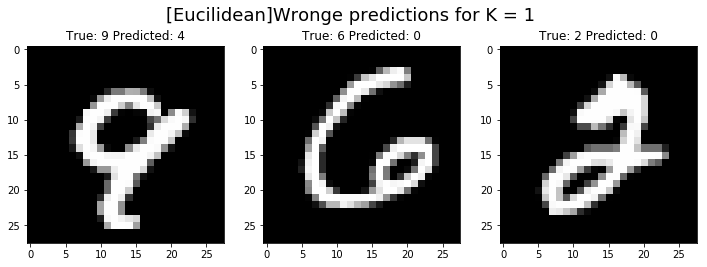

In [24]:
Nrows = 1
Ncols = 3

plt.rcParams["figure.figsize"] = [Ncols*4, Nrows*4]

for i in range(Nrows * Ncols):
    plt.subplot(Nrows, Ncols, i+1)
    plt.imshow(wronge_knn_1_E[i][0].reshape([28, 28]), cmap='Greys_r')
    plt.title('True: ' + str(wronge_knn_1_E[i][2]) + ' Predicted: ' + str(wronge_knn_1_E[i][1]),fontsize=12)
plt.suptitle('[Eucilidean]Wronge predictions for K = {}'.format(K), fontsize = 18) 
plt.show()

### Accuracy vs K for different distance style

In [25]:
dist_type_list = ['Manhattan', 'Eucilidean', 'Minkowski']
q_list = [0.5, 0.7, 1.5, 3, 4]
K_list = [x for x in range(1,21)]

In [26]:
%%time 

acc_knn_list = []
        
for K in K_list:
    print('K = {} running'.format(K))
    acc_knn_list_K = []
    for dis in dist_type_list:
        if dis == 'Minkowski':
            for q in q_list:
                acc_knn_temp, _ = KNN_model_run(train_set, train_labels, test_set, test_labels, K, dis, q)
                acc_knn_list_K.append(acc_knn_temp)
            
        else:
            acc_knn_temp, _ = KNN_model_run(train_set, train_labels, test_set, test_labels, K, dis)
            acc_knn_list_K.append(acc_knn_temp)
    acc_knn_list.append(acc_knn_list_K)

K = 1 running
K = 2 running
K = 3 running
K = 4 running
K = 5 running
K = 6 running
K = 7 running
K = 8 running
K = 9 running
K = 10 running
K = 11 running
K = 12 running
K = 13 running
K = 14 running
K = 15 running
K = 16 running
K = 17 running
K = 18 running
K = 19 running
K = 20 running
Wall time: 17.8 s


In [27]:
label_list = ['Manhattan', 'Eucilidean', 'Minkowski(q = 0.5)', 'Minkowski(q = 0.7)', 'Minkowski(q = 1.5)', 'Minkowski(q = 3)', 'Minkowski(q = 4)']

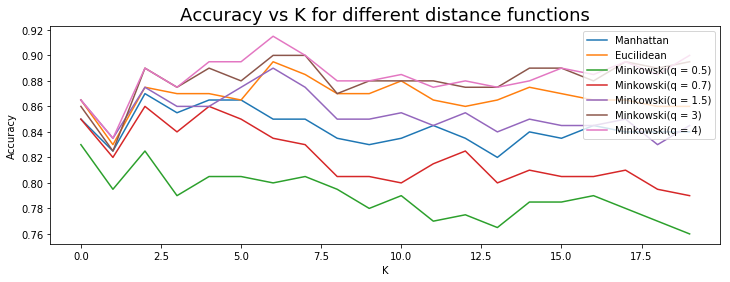

In [28]:
acc_knn_data = np.array(acc_knn_list).T

for i in range(acc_knn_data.shape[0]):
    plt.plot(acc_knn_data[i], label = label_list[i])

plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy vs K for different distance functions', fontsize = 18)
plt.legend(loc='upper right')
plt.show()

In [29]:
i,j = np.unravel_index(acc_knn_data.argmax(), acc_knn_data.shape)
print('Best accuracy = {}, K = {}, distance type = {}'.format(acc_knn_data[i,j], j+1, label_list[i]))

Best accuracy = 0.9150000000000007, K = 7, distance type = Minkowski(q = 4)
